In [88]:
import datetime
import os
import time
import PIL
import pickle
import cv2
import wandb

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tfc

from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard
from keras import callbacks
from wandb.keras import WandbCallback


#import model generators
import stefan_cnn_v1
import oliver_cnn_v1
import sequential_nn

In [89]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.8)

try: sess.close() 
except: pass
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))
tf.executing_eagerly()


Num GPUs Available:  1
Found GPU at: /device:GPU:0


True

### TensorBoard + Callbacks + WandB

In [90]:
#wandb.tensorboard.patch(root_logdir="logs/")

In [115]:
NAME = f"O_CNN{int(time.time())}"

#%load_ext tensorboard
#%tensorboard --logdir logs
wandb.init(project="my-test-project", entity="dolphin_project", sync_tensorboard = True)

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)

epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▅▄▃▃▂▂▂▂▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▇▇▇▇███
val_loss,▁▁▂▄█▃▂▄▃▇▂▂
val_sparse_categorical_accuracy,▅▂▃▅▅█▇▃▁▇▇▄
best_epoch,0
best_val_loss,3.441
epoch,11
loss,0.42355
sparse_categorical_accuracy,0.86118
val_loss,9.0262


## Adjust CSV

In [92]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_labels = list(train_df.species.unique())
images = train_df['image']
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


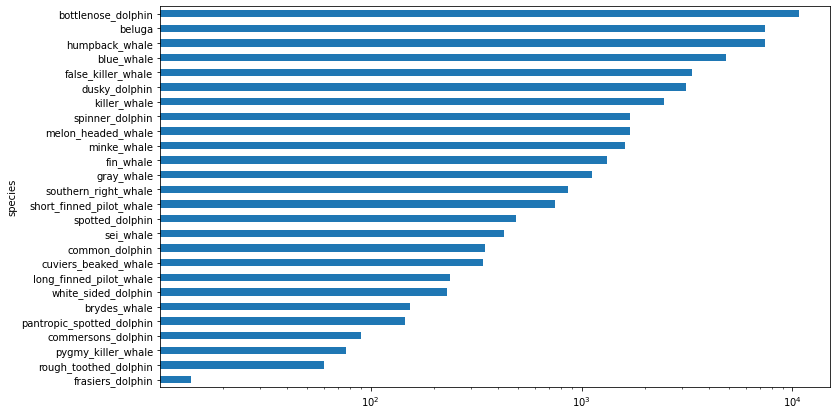

In [93]:
print(f"amount of species: {len(train_df.species.unique())}")
plt.figure(figsize=(12, 7))
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

In [94]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)
labels = train_df["species"]

##one-hot encode species
#train_df = pd.concat([train_df, pd.get_dummies(train_df["species"],prefix='species_',drop_first=True)], axis = 1)
#train_df.drop(['species'],axis=1, inplace=True)
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,0,cadddb1636b9
1,000562241d384d.jpg,1,1a71fbb72250
2,0007c33415ce37.jpg,2,60008f293a2b
3,0007d9bca26a99.jpg,3,4b00fe572063
4,00087baf5cef7a.jpg,1,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,4,5ac053677ed1
51029,fff8b32daff17e.jpg,17,1184686361b3
51030,fff94675cc1aef.jpg,7,5401612696b9
51031,fffbc5dd642d8c.jpg,4,4000b3d7c24e


## Resize Images
This helps the model fitting --> picture preprocessing gets less intensive

In [95]:
SOURCE = "train_images/"
IMG_SIZE = 64
RES = f"train_images_res_{IMG_SIZE}/"

In [ ]:
try:
    os.makedirs(RES)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

for image in tqdm(images):
    savePath = RES + image  
    if not os.path.exists(savePath):
        imgPath = SOURCE + image
        im = Image.open(imgPath)
    
        resizedImage = im.resize((IMG_SIZE, IMG_SIZE), PIL.Image.ANTIALIAS)
        resizedImage.save(savePath) 

In [96]:
full_img = list(map(RES.__add__, images))

## Input Pipeline

In [107]:
BATCH_SIZE = 128
AMT_CLASSES = len(train_df.species.unique())

In [108]:
@tf.function
def process_tuple(image,label):
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels=3)
    
    img = tf.image.random_flip_left_right(img)
    
    img = tf.image.convert_image_dtype(img, tf.float16) / 255
    #img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bicubic', preserve_aspect_ratio=False,antialias=False)
    return img, label

In [109]:
#dataset = tf.data.Dataset.list_files('train_images/*').map(lambda x: tf.py_function(process_path, [x], [tf.float32,tf.int64]))
#dataset = tf.data.Dataset.list_files('train_images/*').map(lambda x: tf.py_function(process_path, [x], [tf.float32,tf.int64]),num_parallel_calls=tf.data.AUTOTUNE)

dataset = tf.data.Dataset.from_tensor_slices((full_img, labels)).shuffle(1000).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

In [110]:
TRAIN_SPLIT = 0.7
VAL_TEST_SPLIT = (1-TRAIN_SPLIT)/2

image_count = dataset.cardinality().numpy()
train_size = int(image_count*TRAIN_SPLIT)
val_test_size = int(image_count*VAL_TEST_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_test_size)
test_ds = dataset.skip(train_size).skip(val_test_size)


train_batched = train_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_batched = val_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### Benchmark Dataset

In [111]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in tqdm(dataset):
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [112]:
benchmark_ds = dataset.take(1)
benchmark(benchmark_ds)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]

Execution time: 0.2024066000012681


## Modelling

In [116]:
INPUT_SHAPE = [IMG_SIZE,IMG_SIZE,3]

ocnn = oliver_cnn_v1.create_model(INPUT_SHAPE)
scnn = stefan_cnn_v1.create_model(INPUT_SHAPE, AMT_CLASSES)
seqnn = sequential_nn.create_model(INPUT_SHAPE)
    
current_model = seqnn
    
#current_model.summary()
current_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=keras.optimizers.Adam(),
             metrics=[
                 tf.keras.metrics.SparseCategoricalAccuracy(),
                 #tf.keras.metrics.Recall(),
                 #tf.keras.metrics.Precision()
             ]) 

In [ ]:
epochs = 300
history = current_model.fit(train_batched,
                   epochs = epochs,
                   validation_data = val_batched,
                   callbacks=[WandbCallback(input_type="image", labels=labels),
                              TensorBoard(log_dir=wandb.run.dir),
                              earlystopping                           
                             ]
                )


wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


Epoch 1/300
279/280 [============================>.] - ETA: 0s - loss: 2.2712 - sparse_categorical_accuracy: 0.3111

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


280/280 [==============================] - 9s 31ms/step - loss: 2.2712 - sparse_categorical_accuracy: 0.3111 - val_loss: 2.0386 - val_sparse_categorical_accuracy: 0.3786
Epoch 2/300
280/280 [==============================] - 8s 30ms/step - loss: 1.9416 - sparse_categorical_accuracy: 0.4007 - val_loss: 1.7898 - val_sparse_categorical_accuracy: 0.4543
Epoch 3/300
280/280 [==============================] - 9s 32ms/step - loss: 1.7689 - sparse_categorical_accuracy: 0.4542 - val_loss: 1.6742 - val_sparse_categorical_accuracy: 0.4846
Epoch 4/300
237/280 [========================>.....] - ETA: 1s - loss: 1.7019 - sparse_categorical_accuracy: 0.4747

In [ ]:
#visualize model performance
accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
fig, (ax1, ax2) = plt.subplots(1, 2)

plt.figure(figsize=(15, 8))
ax1.plot(range(epochs), accuracy, "r", label="Training Accuracy")
ax1.plot(range(epochs), val_accuracy, "orange", label="Validation Accuracy")
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.legend(loc="lower left")

ax2.plot(range(epochs), loss, "b", label="Training Loss")
ax2.plot(range(epochs), val_loss, "g", label="Validation Loss")
ax2.grid(True)
ax2.legend(loc="lower left")
#plt.gca().set_ylim(0, 2)


In [ ]:
cval = current_model.evaluate(test_batched, verbose = 0)

In [ ]:
print("test loss, test acc:", cval)

In [ ]:
with open(f'{current_model}.pkl', 'wb') as file:
    pickle.dump(current_model,file)